# Programming Exercise 8: Anomaly Detection and Recommender Systems
*Code's author: Natália Tenório Maia*<br>
*Solution for [Exercise 8](https://www.coursera.org/learn/machine-learning/home/week/9) of Coursera's Machine Learning course by Andrew Ng.*
<br>
<br>
There are many different ways to solve this exercise. Here you will learn just one possible way, where I tried as much as possible to stick with the original idea proposed in the exercise's pdf.
<br>
<br>
In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies.

## Part 1 - Anomaly detection

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected $m = 307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)},...,x^{(m)} \}$. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian dis- tribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

**Goal:** Implement an anomaly detection algorithm to detect anomalous behavior in server computers.
<br>

In [1]:
import numpy as np                  # package for scientific computing
import matplotlib.pyplot as plt     # plotting library
from scipy.io import loadmat        # package for reading MatLab files
from scipy import optimize as opt   # optimization module in scipy

# Importing data: 
dataset = loadmat('ex8data1.mat')

X = dataset['X']
Xval = dataset['Xval']
yval = dataset['yval']

X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

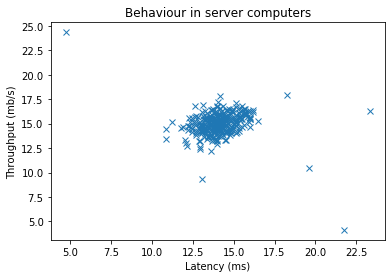

In [2]:
# Plotting data:
plt.plot(X[:,0],X[:,1],'x'); plt.title('Behaviour in server computers')
plt.xlabel('Latency (ms)'); plt.ylabel('Throughput (mb/s)');

### Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution. Given a training set $\{x^{(1)},...,x^{(m)} \}$ (where $x^{(i)} \in \mathbb{R}^{n}$), you want to estimate the Gaussian distribution for each of the features $x_{i}$. For each feature
$i = 1...n$, you need to find parameters $\mu_{i}$ (mean) and $\sigma^{2}_{i}$ (variance) that fit the data in the
i-th dimension $\{x^{(1)},...,x^{(m)} \}$ (the $i$-th dimension of each example).

The Gaussian distribution is given by
$$
p(x,\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}.
$$

### Estimating parameters for a Gaussian


You can estimate the parameters, $(\mu_{i},\sigma^{2}_{i})$, of the $i$-th feature by using the following equations:

$$
\mu_{i}=\frac{1}{m}\sum_{j=1}^{m}x_{i}^{(j)},$$

$$
\sigma^{2}_{i}=\frac{1}{m}\sum_{j=1}^{m}(x_{i}^{(j)}-\mu_{i})^{2}.$$

The function defined below
takes as input the data matrix X and should output an n-dimension vector
mu that holds the mean of all the n features and another n-dimension vector
sigma2 that holds the variances of all the features.

In [3]:
def estimateGaussian(X):
    m = X.shape[0]    
    mu = (1/m)*np.sum(X, axis=0)
    sigma2 = (1/m)*np.sum((X-mu)**2, axis=0)
    return mu, sigma2

In the next part, we will visualize the contours of the fitted Gaussian distribution.

The function in the cell below computes the probability density function of the multivariate gaussian distribution
$$p\left(x;\mu,\Sigma\right)=\frac{e^{-\frac{1}{2}\left(x-\mu\right)^{T}\Sigma^{-1}\left(x-\mu\right)}}{\left(2\pi\right)^{\frac{n}{2}}\left|\Sigma\right|^{\frac{1}{2}}}.$$

In [4]:
def multivariateGaussian(X, mu, sigma2): 
    # If sigma2 is not given as a matrix, make it a matrix:
    if sigma2.ndim == 1:
        sigma2 = np.diag(sigma2)
    # Defining some quantities for convenience:
    n = mu.size
    DetS = np.linalg.det(sigma2)
    C = (2*np.pi)**(-n/2)
    Exp = np.exp( -(1/2)*np.sum(np.dot((X - mu), np.linalg.pinv(sigma2))*(X - mu), axis=1) )
    # Probability density:
    p = C*(DetS**(-1/2))*Exp   
    return p   

We can visualize the dataset and its estimated distribution with the function below:

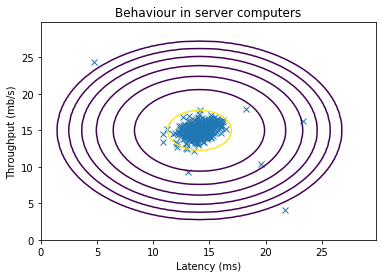

In [5]:
def visualizeFit(X,  mu, sigma2):
    X1, X2 = np.meshgrid(np.arange(0, 30, 0.2), np.arange(0, 30, 0.2))
    Z = multivariateGaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, sigma2)
    Z = Z.reshape(X1.shape)
    # Plotting data:
    plt.plot(X[:, 0], X[:, 1], 'x')
    # Plotting contour:
    plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 0, 3)), zorder=100)
    plt.xlabel('Latency (ms)');plt.ylabel('Throughput (mb/s)');plt.title('Behaviour in server computers');    
    
mu, sigma2 = estimateGaussian(X)
visualizeFit(X,  mu, sigma2)

From your plot, you can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

### Selecting the threshold

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold ε using the F1 score on a cross validation set.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):

$$ F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}, $$

You compute precision and recall by: 

$$ prec = \frac{tp}{tp + fp}  $$ 

$$ rec = \frac{tp}{tp + fn} $$

where: 

- $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.

-  $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
- $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

We will use a cross validation set $\{(x^{(1)},y^{(1)}),...,(x^{(m_{cv})},y^{(m_{cv})}) \}$ , where the label y = 1 corresponds to an anomalous example, and y = 0 corresponds to a normal example. For each cross validation example, we will compute the probability density $p(x^{(i)}_{cv})$.

In the function selectThreshold defined below, there is a loop that will try many different values of ε and select the best ε based on the F1 score. 

In [6]:
def selectThreshold(yval, pval):

    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
 
    stepsize = (max(pval) - min(pval))/1000;
    for epsilon in np.arange(1.015*min(pval), max(pval),stepsize):
        # ====================== YOUR CODE HERE =======================

        h = (pval < epsilon).reshape(-1,1)
        tp = np.sum( (h == 1) & (yval == 1) ) 
        fp = np.sum( (h == 1) & (yval == 0) )
        fn = np.sum( (h == 0) & (yval == 1) )

        prec = tp/(tp+fp)
        rec = tp/(tp+fn)

        F1 = 2*prec*rec/(prec + rec)

        # =============================================================
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    
    return bestEpsilon, bestF1

pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)
epsilon, F1

(8.990852779269493e-05, 0.8750000000000001)

The result above agrees with ex8.pdf and ex8.m . Let's now visualize the dataset with anomalies highlighted:

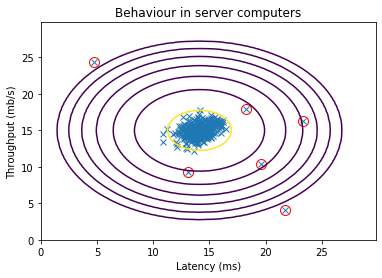

In [7]:
p = multivariateGaussian(X, mu, sigma2)
# The outliers of the dataset are defined by:
outliers = p < epsilon

# Plotting data with probability density and outliers marked with red circles:
visualizeFit(X,  mu, sigma2)
plt.plot(X[outliers,0],X[outliers,1],'ro',ms=10,mfc='None');

### High dimensional dataset

We will now run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

The script will use your code to estimate the Gaussian parameters ($\mu_{i}$ and $\sigma^{2}_{i}$), evaluate the probabilities for both the training data $X$ from which you estimated the Gaussian parameters, and do so for the the cross-validation set $Xval$. Finally, it will use selectThreshold to find the best threshold $\varepsilon$. You should see a value epsilon of about $1.38e^{-18}$, and $117$ anomalies found.

In [8]:
# Importing data: 
dataset = loadmat('ex8data2.mat')
X = dataset['X']
Xval = dataset['Xval']
yval = dataset['yval']

# Estimating Gaussian parameters:
mu, sigma2 = estimateGaussian(X)

# Evaluating probabilities:
p = multivariateGaussian(X, mu, sigma2)
pval = multivariateGaussian(Xval, mu, sigma2)

# Finding the best threshold:
epsilon, F1 = selectThreshold(yval, pval)

# Finding outliers:
outliers = p < epsilon

print('Value for threshold: ',epsilon)
print('Number of outliers: ',len(outliers[outliers == True]))

Value for threshold:  1.3772288916543598e-18
Number of outliers:  117


These results agree with ex8.pdf.

## Part 2: Recommender Systems

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_{u} = 943$ users, and $n_{m} = 1682$ movies. You will implement the function cofiCostFunc that computes the collaborative fitlering objective function and gradient. After implementing the cost function and gradient, you will use scipy.optimize.minimize to
learn the parameters for collaborative filtering.

### Movie ratings dataset

Regarding the cell below, the matrix $Y$ (a num_movies×num_users matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix $R$ is a binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

In [9]:
# Importing data:
dataset = loadmat('ex8_movies.mat')
Y = dataset['Y']
R = dataset['R']

dataset = loadmat('ex8_movieParams.mat')
X = dataset['X']
Theta = dataset['Theta']
num_users = dataset['num_users']
num_movies = dataset['num_movies']
num_features = dataset['num_features']

Y.shape, R.shape, X.shape, Theta.shape

((1682, 943), (1682, 943), (1682, 10), (943, 10))

While $Y_{n_{m}\times n_{u}}$ is the rating matrix and $R_{n_{m}\times n_{u}}$ is the indicator matrix, we will also be working with the feature matrix $X_{n_{m}\times n}$ and the parameter matrix $\Theta_{n_{u}\times n},$ where $n_{m}$ is the number of movies, $n_{u}$ the number of users and $n$ the number of features.

### Collaborative filtering learning algorithm

Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization).

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $\{ x^{(1)},...,x^{(n_{m})}\}$ and $\{ \theta^{(1)},...,\theta^{(n_{u})}\}$, where the model predicts the rating for movie $i$ by user $j$ as $h^{(i,j)} = (θ^{(j)})^{T} x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x$ and $\theta$ that produce the best fit (minimizes the squared error).

#### Collaborative filtering cost function

The collaborative filtering cost function is given by

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( h^{(i,j)} - y^{(i,j)} \right)^2 + \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  + \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2,  $$

while its gradient is

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( h^{(i,j)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)}, $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( h^{(i,j)}- y^{(i,j)} \right) x_k^{(j)} + \lambda \theta_k^{(j)}. $$

You should now write cofiCostFunc to return the cost $J$ and the gradient $grad$. Note that you should be accumulating the cost for user $j$ and movie $i$ only if $R(i,j) = 1$.

A vectorized way of representing the cost function is
$$
J\left(X,\Theta\right)=\frac{1}{2}\sum_{i,j}\left(H\circ R-Y\right)_{i,j}^{2}+\frac{\lambda}{2}\sum_{i,k}X_{i,k}^{2}+\frac{\lambda}{2}\sum_{j,k}\Theta_{j,k}^{2},
$$
and its gradients are
$$
\begin{align*}
\frac{\partial J}{\partial x} & =\left(H\circ R-Y\right)\Theta+\lambda X,\\
\frac{\partial J}{\partial\theta} & =\left(H\circ R-Y\right)^{T}X+\lambda\Theta,
\end{align*}
$$
where
$$
H=X\Theta^{T}.$$

In [10]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lamb):
    # Unfolding the X and Theta matrices from params:
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    # Hypothesis:
    H = np.matmul(X,Theta.T)
    
    # Regularization term:
    Reg = (lamb/2)*( np.sum(Theta**2) + np.sum(X**2) )
    
    # Cost:
    J = (1/2)*np.sum( (H*R - Y)**2 ) + Reg
    
    # Gradients:
    X_grad = np.matmul((H*R - Y),Theta) + lamb*X
    Theta_grad = np.matmul((H*R - Y).T,X) + lamb*Theta 
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    
    return J, grad

In [11]:
# Reducing the data set size so that this runs faster:
num_users = 4
num_movies = 5
num_features = 3

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, 0:num_users]
R = R[:num_movies, 0:num_users]
params = np.concatenate([X.ravel(), Theta.ravel()])

# Computing cost function:
J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features,0)          
print('Cost without regularization: ',J)
J, grad = cofiCostFunc(params,Y, R, num_users, num_movies, num_features, 1.5)
print('Cost with regularization: ',J)

Cost without regularization:  22.224603725685675
Cost with regularization:  31.34405624427422


The result above agrees with ex8_cofi.m .

Let's compare the analytical gradient with the numerical one to see if our implementaion was successful:

In [12]:
def checkCostFunction(cofiCostFunc, lamb):
    # Initializing random values for X and Theta in order to create Y and R:
    X_init = np.random.rand(4, 3); Theta_init = np.random.rand(5, 3)
    # Defining the rating (Y) and the indicator (R) matrices using those initial values of X and Theta:
    Y = np.matmul(X_init, Theta_init.T)
    Y[np.random.rand(*Y.shape) > 0.5] = 0   # Creating some random null entries to simulate unrated movies
    R = np.zeros(Y.shape) ; R[Y != 0] = 1
    
    # Initializing our random feature (X) and parameter (Theta) matrices:
    X = np.random.randn(*X_init.shape)
    Theta = np.random.randn(*Theta_init.shape)
    num_movies, num_users = Y.shape; num_features = Theta_init.shape[1]
    params = np.concatenate([X.ravel(), Theta.ravel()])
    
    # Numerical Gradient:
    epsilon = 1e-4
    numgrad = np.zeros(params.shape)
    perturb = np.diag(epsilon * np.ones(params.shape))
    for i in range(params.size):
        loss1 = cofiCostFunc((params - perturb[:, i]), Y, R, num_users, num_movies, num_features, lamb)[0]
        loss2 = cofiCostFunc((params + perturb[:, i]), Y, R, num_users, num_movies, num_features, lamb)[0]
        numgrad[i] = (loss2 - loss1)/(2*epsilon)
        
    # Analytical Gradient:
    grad = cofiCostFunc(params, Y, R, num_users,num_movies, num_features, lamb)[1]
    
    # Difference between gradients:
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)
    
    print("Regularization parameter = "+str(lamb)); print()
    print("Numerical gradient, first five entries:"); print(numgrad[:5]); print()
    print("Analytical gradient, first five entries:"); print(grad[:5]); print()
    print("The relative difference between gradients should be smaller than e-9: "+str(diff))
    
checkCostFunction(cofiCostFunc, 1.5)

Regularization parameter = 1.5

Numerical gradient, first five entries:
[ 0.80283073  1.87338317  0.13715314 11.14771529 -4.0428485 ]

Analytical gradient, first five entries:
[ 0.80283073  1.87338317  0.13715314 11.14771529 -4.0428485 ]

The relative difference between gradients should be smaller than e-9: 1.934782321104511e-12


### Learning movie recommendations

After you have finished implementing the collaborative filtering cost function and gradient, you can now start training your algorithm to make movie recommendations for yourself.

In the next part, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations! We have filled out some values according to our own preferences, but you should change this according to your own tastes. The list of all movies and their number in the dataset can be found listed in the file movie_idx.txt.

Before we training the collaborative filtering model, we will first add ratings that correspond to a new user that we just observed. This part of the code will also allow you to put in your own ratings for the movies in our dataset!

In [13]:
# Loading movie list:
with open('movie_ids.txt',  encoding='ISO-8859-1') as mov:
    movies = mov.readlines()
movieList = []
for movie in movies:
    parts = movie.split()
    movieList.append(' '.join(parts[1:]).strip())
num_movies = len(movieList)

# Initializing my ratings:
my_ratings = np.zeros(num_movies)
# Check the file movie_idx.txt for id of each movie in our dataset.
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4
# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2
# We have selected a few movies we liked/did not like and the ratings we gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('======= New user ratings =======')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

======= New user ratings =======
Rated 4 stars: Toy Story (1995)
Rated 3 stars: Twelve Monkeys (1995)
Rated 5 stars: Usual Suspects, The (1995)
Rated 4 stars: Outbreak (1995)
Rated 5 stars: Shawshank Redemption, The (1994)
Rated 3 stars: While You Were Sleeping (1995)
Rated 5 stars: Forrest Gump (1994)
Rated 2 stars: Silence of the Lambs, The (1991)
Rated 4 stars: Alien (1979)
Rated 5 stars: Die Hard 2 (1990)
Rated 5 stars: Sphere (1998)


#### Recommendations

After the additional ratings have been added to the dataset, the script will proceed to train the collaborative filtering model. This will learn the parameters $X$ and $\Theta$. To predict the rating of movie $i$ for user $j$, you need to compute $(\theta^{(j)})^{T}x^{(i)}$.

In [14]:
# First let's define a function to normalize the ratings:
def normalizeRatings(Y, R):
    m, n = Y.shape; Ymean = np.zeros(m); Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    return Ynorm, Ymean

The next part of the script computes the ratings for all the movies and users and displays the movies that it recommends, according to ratings that were entered earlier in the script. Note that you might obtain a different set of the predictions due to different random initializations.

In [15]:
# Importing data:
dataset = loadmat('ex8_movies.mat')
Y = dataset['Y']
R = dataset['R']

# Adding our own ratings to the data matrix as a new column:
my_ratings = my_ratings.reshape(-1,1)
Y = np.hstack([my_ratings, Y])
R = np.hstack([(my_ratings > 0), R])

# Normalizing Ratings:
Ynorm, Ymean = normalizeRatings(Y, R)

# Useful Values:
num_movies, num_users = Y.shape
num_features = 10

# Setting Initial Parameters (Theta, X):
X = np.random.randn(num_movies, num_features); Theta = np.random.randn(num_users, num_features)
initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Now let's use opt.minimize to compute the parameters:
res = opt.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users, num_movies, num_features, 10),
                        initial_parameters,method='TNC',jac=True,options={'maxiter': 100})
theta = res.x

# Unfolding the returned theta back into X and Theta:
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)
print('Recommender system learning completed.')

Recommender system learning completed.


After training the model, you can now make recommendations by computing the predictions matrix.

In [16]:
p = np.matmul(X, Theta.T)
my_predictions = p[:, 0] + Ymean
# In an array, let's organizing the indices that would sort my_predictions in descending order:
idx = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('--------------------------')

for i in range(11):
    print('Predicting rating %.1f for movie %s' % (my_predictions[idx[i]], movieList[idx[i]]))

print('\n\nOriginal ratings provided:')
print('--------------------------')

for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Top recommendations for you:
--------------------------
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 4.6 for movie Pather Panchali (1955)


Original ratings provided:
--------------------------
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping 

End of exercise 8.